In [286]:
### Houskeeping / Packages

from dtaidistance import dtw
from dtaidistance import clustering
from dtaidistance import dtw_visualisation as dtwvis
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [287]:
### Read (hist) data

df_hist = pd.read_csv('../historical_data.csv')
df_hist.rename(columns={'Unnamed: 0': 'month'}, inplace=True)
df_hist.rename(columns={'Month': 'month_bw'}, inplace=True)
df_hist.fillna(0, inplace=True)

df_hist.head()

,month,month_bw,negaffect,posaffect,eafric,easian,egend,iafric,iasian,igend,lifesat,ideoldem,ideolrep,polar,COVID_cases,COVID_deaths
0,1,-39,0.950695,-0.790772,0.078327,-0.052799,0.901150,0.328345,0.344996,0.349023,6.216210,46.500000,41.000000,77.000000,0.0,0.0
1,2,-38,0.811725,-0.761614,0.017314,-0.019368,0.840420,0.316904,0.385169,0.376662,6.211950,45.800000,43.620000,77.400000,0.0,0.0
2,3,-37,1.101026,-1.165077,0.010376,0.025948,0.847847,0.335264,0.407157,0.386734,6.198868,44.980000,41.120000,76.666667,0.0,0.0
3,4,-36,1.437233,-1.334346,0.033963,-0.141032,0.911211,0.335224,0.382096,0.379282,6.252538,43.375000,39.625000,77.500000,0.0,0.0
4,5,-35,0.860613,-0.527818,0.104510,-0.034130,0.887819,0.339972,0.390606,0.383958,6.315386,40.903704,35.196296,76.400000,0.0,0.0


In [288]:
#### Normlize entire dataframe
#(see: https://www.journaldev.com/45109/normalize-data-in-python)
#(see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

#With normalize() --> For each column create unit norm 
#                    (sum of all squared values equals 1, in a range between 1 and -1)
d = preprocessing.normalize(df_hist, axis=0)# axis=0 for normalization in columns instead of rows
df_hist_norm = pd.DataFrame(d, columns=df_hist.columns)
df_hist_norm = df_hist_norm.drop(["month", "month_bw"], axis=1)

#With MinMaxScaler() --> Scale with (x-xmin)/(xmax-xmin) for each column (only range of data changes)
scaler = preprocessing.MinMaxScaler() 
d = scaler.fit_transform(df_hist)
df_hist_scale = pd.DataFrame(d, columns=df_hist.columns)
df_hist_scale = df_hist_scale.drop(["month", "month_bw"], axis=1)

#With StandardScaler() --> Standardizing to unit variance with y = (x – mean) / standard_deviation
standarizer = preprocessing.StandardScaler() 
d = standarizer.fit_transform(df_hist)
df_hist_standard = pd.DataFrame(d, columns=df_hist.columns)
df_hist_standard = df_hist_standard.drop(["month", "month_bw"], axis=1)
                                     
#df_hist_norm.head()
#df_hist_scale.head()
#df_hist_standard.head()

In [8]:
### Comparison of two timeseries

s1 = np.array(df_hist_norm.iasian)
s2 = np.array(df_hist_norm.iafric)
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="Comparions_iasian_iafric.png")

(None, None)

In [289]:
### Comparison of multiple timeseries in a distance matrix

array_norm = np.transpose(np.array(df_hist_norm))
distance_matrix = pd.DataFrame(dtw.distance_matrix(array_norm),
                               columns=df_hist_norm.columns,
                               index=df_hist_norm.columns)

array_scale = np.transpose(np.array(df_hist_scale))
distance_matrix = pd.DataFrame(dtw.distance_matrix(array_scale),
                               columns=df_hist_scale.columns,
                               index=df_hist_scale.columns)

array_standard = np.transpose(np.array(df_hist_standard))
distance_matrix = pd.DataFrame(dtw.distance_matrix(array_standard),
                               columns=df_hist_standard.columns,
                               index=df_hist_standard.columns)

In [293]:
### Clustering (using the distance matrix)

# SciPy linkage clustering normalize()-based
model_norm = clustering.LinkageTree(dtw.distance_matrix, {})
cluster_idx = model_norm.fit(array_norm)

# SciPy linkage clustering MinMaxScale()-based
model_scale = clustering.LinkageTree(dtw.distance_matrix, {})
cluster_idx = model_scale.fit(array_scale)

# SciPy linkage clustering Standardscale()-based
model_standard = clustering.LinkageTree(dtw.distance_matrix, {})
cluster_idx = model_standard.fit(array_standard)

# Plotting of the differently normalized data in comparison

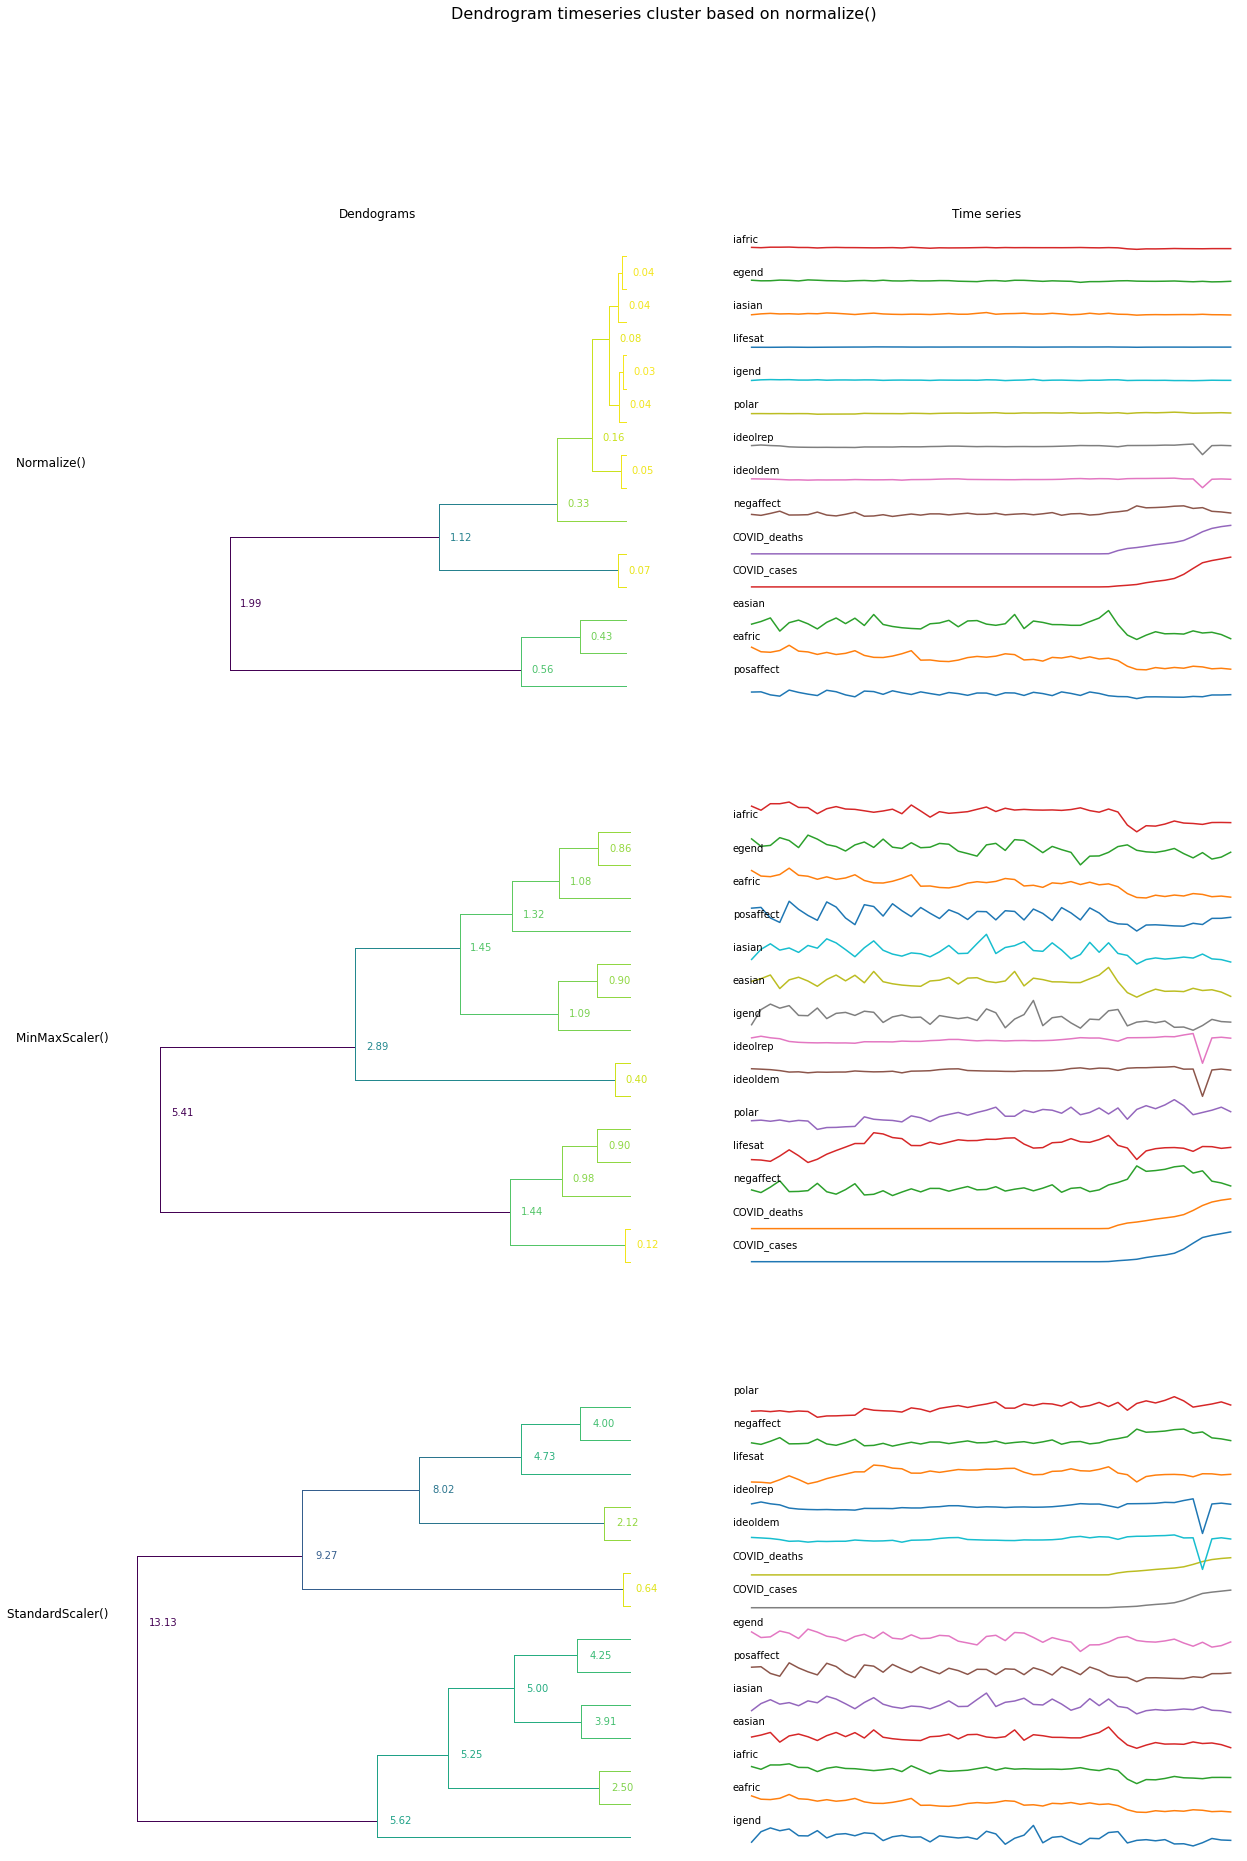

In [291]:
### Plotting Dendrogram based on normalize()

cols = ['Column {}'.format(col) for col in range(1, 2)]
rows = ['Row {}'.format(row) for row in ['A', 'B']]

# Create figure shell
fig_all, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))

# Add normalize()-based cluster
show_ts_label = df_hist_norm.columns
model_norm.plot("LinkageTree_Dendrogram.png", axes=(ax[0,0],ax[0,1]), ts_height=20,
            bottom_margin=10, top_margin=0.1,
            show_ts_label=show_ts_label, ts_label_margin=-10,
            show_tr_label=True, tr_label_margin=0.1,
            ts_left_margin=10, ts_sample_length=5,
            tr_left_margin=1,
            cmap='viridis_r', ts_color=None)

# Add MinMaxScaler()-based cluster
show_ts_label = df_hist_scale.columns
model_scale.plot("LinkageTree_Dendrogram.png", axes=(ax[1,0],ax[1,1]), ts_height=20,
            bottom_margin=10, top_margin=0.1,
            show_ts_label=show_ts_label, ts_label_margin=-10,
            show_tr_label=True, tr_label_margin=0.3,
            ts_left_margin=10, ts_sample_length=5,
            tr_left_margin=1,
            cmap='viridis_r', ts_color=None)

# Add StandardScaler()-based cluster
show_ts_label = df_hist_standard.columns
model_standard.plot("LinkageTree_Dendrogram.png", axes=(ax[2,0],ax[2,1]), ts_height=20,
            bottom_margin=10, top_margin=0.1,
            show_ts_label=show_ts_label, ts_label_margin=-10,
            show_tr_label=True, tr_label_margin=1,
            ts_left_margin=10, ts_sample_length=5,
            tr_left_margin=1,
            cmap='viridis_r', ts_color=None)

#Title name
fig_all.suptitle('Dendrogram timeseries cluster based on normalize()', fontsize=16)

#Annotate row and column labels
ax[0,0].annotate("Dendograms", xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
ax[0,1].annotate("Time series", xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

    
ax[0,0].annotate("Normalize()          ", xy=(0, 0.5), xytext=(0,0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='right', va='center')
ax[1,0].annotate("MinMaxScaler()    ", xy=(0, 0.5), xytext=(0,0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='right', va='center')
ax[2,0].annotate("StandardScaler()    ", xy=(0, 0.5), xytext=(0,0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='right', va='center')

fig_1.tight_layout()
fig_all

# Single plot based on scaling to unit norm

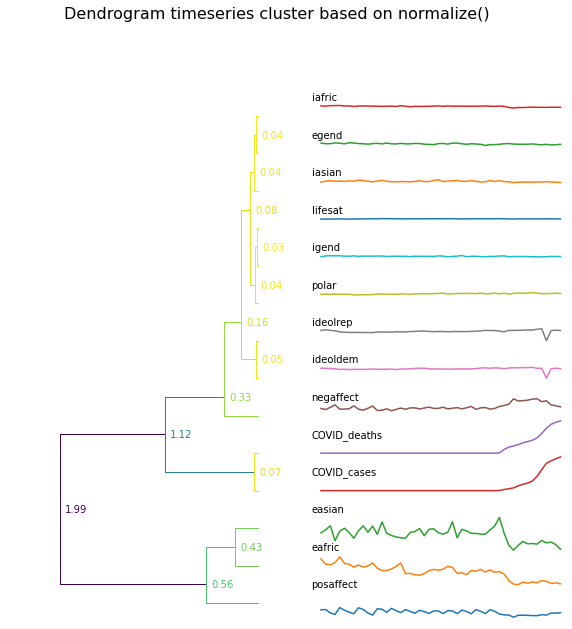

In [273]:
### Plotting Dendrogram based on normalize()

# LinkageTree normalize()-based
fig_norm, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = df_hist_norm.columns
model_norm.plot("LinkageTree_Dendrogram.png", axes=(ax[0],ax[1]), ts_height=20,
            bottom_margin=10, top_margin=0.1,
            show_ts_label=show_ts_label, ts_label_margin=-10,
            show_tr_label=True, tr_label_margin=0.1,
            ts_left_margin=10, ts_sample_length=5,
            tr_left_margin=1,
            cmap='viridis_r', ts_color=None)

fig_norm.suptitle('Dendrogram timeseries cluster based on normalize()', fontsize=16)
#fig_1.tight_layout()
fig_norm

# Single plot based on simple scaling of the range (My favorite)

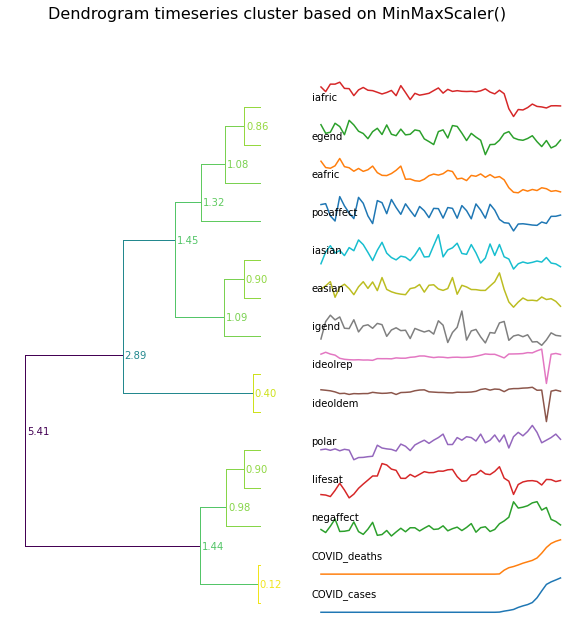

In [292]:
### Plotting Dendrogram based on MinMaxScaler()

# LinkageTree MinMaxScaler()-based
fig_scale, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = df_hist_scale.columns
model_scale.plot("LinkageTree_Dendrogram.png", axes=(ax[0],ax[1]), ts_height=20,
            bottom_margin=5, top_margin=0.1,
            show_ts_label=show_ts_label, ts_label_margin=-10,
            show_tr_label=True, tr_label_margin=0.1,
            ts_left_margin=10, ts_sample_length=5,
            tr_left_margin=1,
            cmap='viridis_r', ts_color=None)

fig_scale.suptitle('Dendrogram timeseries cluster based on MinMaxScaler()', fontsize=16)
#fig_1.tight_layout()
fig_scale